In [31]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(r"./Images", image_size = (224,224), batch_size = 40, label_mode = "int", shuffle = True)

Found 200 files belonging to 2 classes.


In [18]:
class_names = dataset.class_names
class_names

['alligator', 'shark']

In [19]:
len(dataset)

5

In [20]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(40, 224, 224, 3)
[0 1 1 0 0 1 0 1 1 1 1 0 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 0 1
 1 0 0]


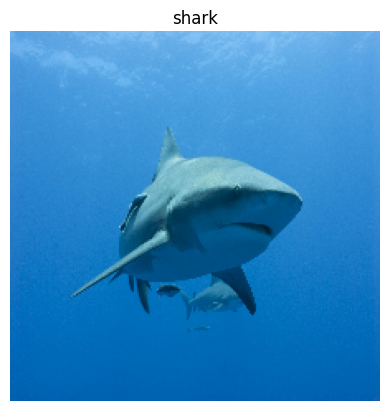

In [21]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[1].numpy().astype("uint8"))
    plt.title(class_names[label_batch[1]])
    plt.axis("off")

In [22]:
train_ds = dataset.take(4)
test_ds = dataset.skip(4)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(224,224),
    layers.Rescaling(1.0/255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [23]:
model_VGG_Block_1 = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(64, (3,3), activation = "relu", padding = "same", input_shape = (40,224,224,3)),
    layers.Conv2D(64, (3,3), activation = "relu", padding = "same"),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Flatten(),
    layers.Dense(64, activation= "relu"),
    layers.Dense(2, activation = "softmax")
])

model_VGG_Block_1.build(input_shape= (40,224,224,3))

In [24]:
model_VGG_Block_3 = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(64, (3,3), activation = "relu", padding = "same", input_shape = (40,224,224,3)),
    layers.Conv2D(64, (3,3), activation = "relu", padding = "same"),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Conv2D(128, (3,3), activation = "relu", padding = "same", input_shape = (40,224,224,3)),
    layers.Conv2D(128, (3,3), activation = "relu", padding = "same"),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Conv2D(256, (3,3), activation = "relu", padding = "same", input_shape = (40,224,224,3)),
    layers.Conv2D(256, (3,3), activation = "relu", padding = "same"),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Flatten(),
    layers.Dense(64, activation= "relu"),
    layers.Dense(2, activation = "softmax")
])

model_VGG_Block_3.build(input_shape=(40,224,224,3))

In [25]:
model_VGG_Block_3_data_augmentation = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(64, (3,3), activation = "relu", padding = "same", input_shape = (40,224,224,3)),
    layers.Conv2D(64, (3,3), activation = "relu", padding = "same"),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Conv2D(128, (3,3), activation = "relu", padding = "same", input_shape = (40,224,224,3)),
    layers.Conv2D(128, (3,3), activation = "relu", padding = "same"),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Conv2D(256, (3,3), activation = "relu", padding = "same", input_shape = (40,224,224,3)),
    layers.Conv2D(256, (3,3), activation = "relu", padding = "same"),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Flatten(),
    layers.Dense(64, activation= "relu"),
    layers.Dense(2, activation = "softmax")
])

model_VGG_Block_3_data_augmentation.build(input_shape = (40,224,224,3))

In [26]:
vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16.trainable = True  

model_transfer_learning_all_layers = tf.keras.Sequential([
    vgg16,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax') 
])

In [27]:
vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16.trainable = False  

model_transfer_learning_mlp = tf.keras.Sequential([
    vgg16,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')  
])



In [ ]:
model_MLP = models.Sequential([
    resize_and_rescale,  
    layers.Flatten(input_shape=(224, 224, 3)),  
    layers.Dense(4096, activation='relu'), 
    layers.Dropout(0.4),  
    layers.Dense(2048, activation='relu'),  
    layers.Dropout(0.3),  
    layers.Dense(1024, activation='relu'), 
    layers.Dropout(0.2),  
    layers.Dense(2, activation='softmax')  
])


In [ ]:
import time
import pandas as pd
import gc
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.mixed_precision import set_global_policy

set_global_policy('mixed_float16')

pd.set_option('display.width', 1000)
results_table = pd.DataFrame(columns=["Model", "Training Time (s)", "Training Loss", "Training Accuracy", "Testing Accuracy", "Parameters"])

def eval_model(model, train_data, test_data, model_name, epoch):
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=r"D:/logs", histogram_freq=1)

    model.compile(optimizer="adam", 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                  metrics=["accuracy"])

    start_time = time.time()
    history = model.fit(
        train_data,
        epochs=epoch,
        batch_size=2,  
        verbose=1,
        callbacks=[tensorboard_callback]
    )
    training_time = time.time() - start_time

    training_loss = history.history["loss"][-1]
    training_accuracy = history.history["accuracy"][-1]
    _, test_accuracy = model.evaluate(test_data)
    param_count = model.count_params()

    results_table.loc[len(results_table)] = [
        model_name,
        f"{training_time:.2f}",
        f"{training_loss:.4f}",
        f"{training_accuracy:.2f}",
        f"{test_accuracy:.2f}",
        f"{param_count:,}"
    ]

    print(f"Model {model_name} evaluated successfully.")

    del model
    gc.collect()
    tf.keras.backend.clear_session()

train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

print("Evaluating VGG_Block_1...")
eval_model(model_VGG_Block_1, train_ds, test_ds, "VGG_Block_1", 2)
print("Evaluating VGG_Block_3...")
eval_model(model_VGG_Block_3, train_ds, test_ds, "VGG_Block_3", 2)
print("Evaluating VGG_Block_3_Data_Augmentation...")
eval_model(model_VGG_Block_3_data_augmentation, train_ds, test_ds, "VGG_Block_3_data_augmentation", 2)
print("Evaluating Transfer Learning (All Layers)...")
eval_model(model_transfer_learning_all_layers, train_ds, test_ds, "transfer_learning_all_layer", 2)
print("Evaluating Transfer Learning (MLP Layers)...")
eval_model(model_transfer_learning_mlp, train_ds, test_ds, "transfer_learning_mlp", 2)
print("Evaluating MLP (MLP Layers)...")
eval_model(model_MLP, train_ds, test_ds, "Model_MLP", 2)

print(results_table)

results_table.to_csv("Final_Results.csv", index=False)
print("Results saved to 'Final_Results.csv'.")


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing import image

generated_images = {
    "A_Easy": "/kaggle/input/generated/GeneratedImages/A_Easy.jpg",
    "A_Hard": "/kaggle/input/generated/GeneratedImages/A_Hard.jpg",
    "B_Easy": "/kaggle/input/generated/GeneratedImages/B_Easy.jpg",
    "B_Hard": "/kaggle/input/generated/GeneratedImages/B_Hard.jpg",
}

models = {
    "VGG_Block_1": model_VGG_Block_1,
    "VGG_Block_3": model_VGG_Block_3,
    "VGG_Block_3_Data_Augmentation": model_VGG_Block_3_data_augmentation,
    "Transfer_Learning_All_Layers": model_transfer_learning_all_layers,
    "Transfer_Learning_MLP": model_transfer_learning_mlp,
    "MLP_Model": model_MLP,
}

results_list = []

def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0 
    return img_array

class_map = {0: "Alligator", 1: "Shark"}

for model_name, model in models.items():
    print(f"Evaluating model: {model_name}")

    for img_label, img_path in generated_images.items():
        img_array = preprocess_image(img_path)

        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions)
        confidence = np.max(predictions)

        predicted_class_name = class_map[predicted_class]

        results_list.append({
            "Model": model_name,
            "Image": img_label,
            "Predicted Class": predicted_class_name,
            "Confidence": confidence
        })

results = pd.DataFrame(results_list)

results.to_csv("GeneratedImage_Results.csv", index=False)
print("Results saved to 'GeneratedImage_Results.csv'")


Evaluating model: VGG_Block_1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Evaluating model: VGG_Block_3
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Evaluating model: VGG_Block_3_Data_Augmentation
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Evaluating model: Transfer_Learning_All_Layers
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Evaluating model: Transfer_Learning_MLP
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Evaluating model: MLP_Model
1/1 ━━━━━━━━━━━━━━━

In [ ]:
# TEnsorboard

# tensorboard --logdir="C:\Users\Vansh\Desktop\Coding\ML\Final Assignment 4"
